Code an AutoEncoder using Keras
<br> # https://blog.keras.io/building-autoencoders-in-keras.html

Import Packages

In [29]:
import numpy as np
import seaborn as sns
import scipy.io as sio
import random
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
% matplotlib inline

# AlexNet Dependencies
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input, Dropout, Dense, Activation,BatchNormalization, Flatten, Conv2D, LeakyReLU, MaxPooling2D, UpSampling2D
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import Model, model_from_json
from tensorflow.python.keras import backend as K

from sklearn.metrics import confusion_matrix

Define Helper Functions

In [11]:
# Converts integer labels into one-hot vectors
def to_one_hot(labels, n_classes, p_max = 1.0):
    # Calculate the minimum probability of class based on max probability
    p_min = 0.0 if p_max == 1.0 else (1.0 - p_max)/(n_classes - 1)

    # allocate memory for one hot labels
    labels = labels.astype(np.int32)
    n_labels = labels.shape[0]
    oh_labels = np.full((n_labels, n_classes), p_min)
    # minus 1 because Matlab uses 1 based indexing
    oh_labels[np.arange(n_labels), labels-1] = p_max
    return oh_labels

def to_int_label(labels):
    int_labels = np.zeros((len(labels),))
    for i in range(len(labels)):
        int_labels[i] = np.argmax(labels[i])
    return int_labels

# Convert batch, pixels --> batch, rows, cols, 1_channel
def to_img(x):
    return np.reshape(x, [-1, im_rows, im_cols, 1])


# Restore values from memory (TF also supports restoring from a file)
def set_best_vars(sess, best_vars_vals, trainable_vars):
    restore_ops = [avar.assign(best_val) for best_val, avar in zip(best_vars_vals, trainable_vars)]
    sess.run(restore_ops)

Define Constants

In [12]:
## To speed up validation
MAX_VALIDATION_SAMPLES = int(2000) # at most 10,000 in this dataset

Import Data

In [13]:
TRAINING_FILE = '../training.mat'
VALIDATION_FILE = '../validation.mat'
TESTING_FILE = '../testing.mat'

In [14]:
## Data
print('Loading Training Data')
training_data = sio.loadmat(TRAINING_FILE, squeeze_me=True)
training_ims = training_data['data'].T  # .T --> transpose
training_labels = training_data['labels']

# Validation Data
print('Loading Validation Data')
validation_data = sio.loadmat(VALIDATION_FILE, squeeze_me=True)
validation_ims = validation_data['data'].T
validation_labels = validation_data['labels']
# Limit our Validation data since we don't really need 10k of them
validation_ims = validation_ims[:MAX_VALIDATION_SAMPLES]
validation_labels = validation_labels[:MAX_VALIDATION_SAMPLES]


# Testing data
print('Loading Testing Data')
testing_data = sio.loadmat(TESTING_FILE, squeeze_me=True)
testing_ims = testing_data['data'].T
testing_labels = testing_data['labels']

Loading Training Data
Loading Validation Data
Loading Testing Data


Data Attributes

In [15]:
## Data attributes (look them up, but are effectively constant)
# These could be hard coded, but extracting them from the data anyway
im_rows = im_cols = int(np.sqrt(testing_ims.shape[1]))
print('Number of Rows/Cols:', im_rows)
num_classes = int(np.amax(testing_labels))
print('Number of Classes:', num_classes)

Number of Rows/Cols: 28
Number of Classes: 10


Data Pre-processing

In [16]:
## Data preprocessing
print('Reformating labels to one-hot')
training_labels   = to_one_hot(training_labels, num_classes)
validation_labels = to_one_hot(validation_labels, num_classes)
testing_labels    = to_one_hot(testing_labels, num_classes)

# print('Reshaping data from [img, pixels] to [img, row, col, channel]')
# training_ims   = np.reshape(training_ims, (-1, im_rows, im_cols, 1))
# validation_ims = np.reshape(validation_ims, (-1, im_rows, im_cols, 1))
# testing_ims    = np.reshape(testing_ims, (-1, im_rows, im_cols, 1))

Reformating labels to one-hot


In [33]:
np.shape(training_ims)

(50000, 784)

In [43]:
x_train = training_ims.astype('float32') / 255.
x_val   = validation_ims.astype('float32') / 255.
x_test  = testing_ims.astype('float32') / 255.

x_train = x_train.reshape((len(x_train),28,28,1))
x_val   = x_val.reshape((len(x_val),28,28,1))
x_test  = x_test.reshape((len(x_test),28,28,1))
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(50000, 28, 28, 1)
(2000, 28, 28, 1)
(10000, 28, 28, 1)


In [50]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = rand(28 * 28 * n_samples)
    # reshape into a batch of grayscale images
    X = X.reshape((n_samples, 28, 28, 1))
    # generate 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [ ]:
half_batch = int(n_batch / 2)

In [44]:
INPUT_SHAPE = [im_rows,im_cols,1]
BATCH_SIZE = int(100)
MAX_ITER = int(500000)  # 5 million should be enough
WEIGHT_DECAY = 5e-4  # This is what AlexNet used

# Discriminator Model

In [45]:
def Discriminator(input_shape=(28,28,1)):
    
    # Input Image
    X_input = Input(shape=input_shape,name = "input")
    
    X = Conv2D(64, (3,3), strides=(2, 2), padding='same', name="conv0")(X_input)
    X = LeakyReLU(alpha=0.2)(X)
    X = Dropout(0.4)(X)
    
    X = Conv2D(64, (3,3), strides=(2, 2), padding='same', name="conv1")(X)
    X = LeakyReLU(alpha=0.2)(X)
    X = Dropout(0.4)(X)
    
    X = Flatten()(X)
    
    X = Dense(1, activation = 'sigmoid', name = "fc0")(X)
    
    # Model that maps input to its reconstruction
    model = Model(inputs = X_input, outputs = X, name='discriminator')

    return model

In [46]:
m = Discriminator()

In [47]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 64)          0         
__________

In [48]:
m.compile(optimizer = Adam(lr=0.0002, beta_1=0.5) , loss = 'binary_crossentropy' , metrics=['accuracy'])

In [49]:
history = m.fit(x_train,training_labels, 
                batch_size=BATCH_SIZE, epochs=50, 
                validation_data=(x_val, validation_labels))

ValueError: Error when checking target: expected fc0 to have shape (1,) but got array with shape (10,)

In [74]:
from numpy.random import randint, rand

In [75]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances    
    ix = randint(0, dataset.shape[0], n_samples)
    
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = rand(28 * 28 * n_samples)
    # reshape into a batch of grayscale images
    X = X.reshape((n_samples, 28, 28, 1))
    # generate 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

In [76]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [77]:
# define the discriminator model
model = Discriminator()

model.compile(optimizer = Adam(lr=0.0002, beta_1=0.5) , loss = 'binary_crossentropy' , metrics=['accuracy'])

# load image data
dataset = x_train
# fit the model
train_discriminator(model, dataset)

50000
128
>1 real=50% fake=36%
50000
128
>2 real=100% fake=84%
50000
128
>3 real=100% fake=98%
50000
128
>4 real=100% fake=99%
50000
128
>5 real=99% fake=100%
50000
128
>6 real=100% fake=100%
50000
128
>7 real=100% fake=100%
50000
128
>8 real=100% fake=100%
50000
128
>9 real=100% fake=100%
50000
128
>10 real=100% fake=100%
50000
128
>11 real=100% fake=100%
50000
128
>12 real=100% fake=100%
50000
128
>13 real=100% fake=100%
50000
128
>14 real=100% fake=100%
50000
128
>15 real=100% fake=100%
50000
128
>16 real=100% fake=100%
50000
128
>17 real=100% fake=100%
50000
128
>18 real=100% fake=100%
50000
128
>19 real=100% fake=100%
50000
128
>20 real=100% fake=100%
50000
128
>21 real=100% fake=100%
50000
128
>22 real=100% fake=100%
50000
128
>23 real=100% fake=100%
50000
128
>24 real=100% fake=100%
50000
128
>25 real=100% fake=100%
50000
128
>26 real=100% fake=100%
50000
128
>27 real=100% fake=100%
50000
128
>28 real=100% fake=100%
50000
128
>29 real=100% fake=100%
50000
128
>30 real=100% fake=

# Simplified AutoEncoder

In [15]:
# Input Dimension
input_dim = im_rows*im_cols

# Dimension of encoded representation
encoding_dim = 32

In [16]:
def AutoEncoder(input_dim, encoding_dim):
    
    # Input Image
    X_input = Input(shape=(input_dim,),name = "input")
    
    # Encoded representation of input
    X = Dense(encoding_dim, activation='relu', name = "encoder")(X_input)
    
    # Decoded / lossy reconstruction of input
    X = Dense(input_dim, activation='sigmoid', name = "decoder")(X)
    
    # Model that maps input to its reconstruction
    model = Model(inputs = X_input, outputs = X, name='AutoEncoder')

    return model

In [17]:
autoencoder = AutoEncoder(input_dim, encoding_dim)

In [18]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Dense)              (None, 32)                25120     
_________________________________________________________________
decoder (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [19]:
autoencoder.compile(optimizer = 'adam' , loss = 'binary_crossentropy')

In [20]:
autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val, x_val))

Train on 50000 samples, validate on 2000 samples
Epoch 1/200
50000/50000 [==============================] - 2s 40us/step - loss: 0.4959 - val_loss: 0.2149
Epoch 2/200
50000/50000 [==============================] - 1s 29us/step - loss: 0.0994 - val_loss: 0.0427
Epoch 3/200
50000/50000 [==============================] - 1s 27us/step - loss: 0.0274 - val_loss: 0.0179
Epoch 4/200
50000/50000 [==============================] - 2s 33us/step - loss: 0.0138 - val_loss: 0.0109
Epoch 5/200
50000/50000 [==============================] - 2s 33us/step - loss: 0.0092 - val_loss: 0.0080
Epoch 6/200
50000/50000 [==============================] - 2s 35us/step - loss: 0.0072 - val_loss: 0.0065
Epoch 7/200
50000/50000 [==============================] - 2s 33us/step - loss: 0.0061 - val_loss: 0.0058
Epoch 8/200
50000/50000 [==============================] - 2s 32us/step - loss: 0.0055 - val_loss: 0.0053
Epoch 9/200
50000/50000 [==============================] - 2s 33us/step - loss: 0.0051 - val_loss: 0.00

50000/50000 [==============================] - 1s 24us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 154/200
50000/50000 [==============================] - 2s 32us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 155/200
50000/50000 [==============================] - 2s 34us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 156/200
50000/50000 [==============================] - 1s 30us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 157/200
50000/50000 [==============================] - 1s 29us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 158/200
50000/50000 [==============================] - 1s 26us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 159/200
50000/50000 [==============================] - 1s 28us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 160/200
50000/50000 [==============================] - 1s 26us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 161/200
50000/50000 [==============================] - 2s 31us/step - loss: 0.0038 - val_loss: 0.0038
Epoch 162/200
50000/50000 [===============

In [21]:
layer_name = 'encoder'
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)
encoded_imgs = encoder.predict(x_test)

layer_name = 'decoder'
decoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)
decoded_imgs = decoder.predict(x_test)

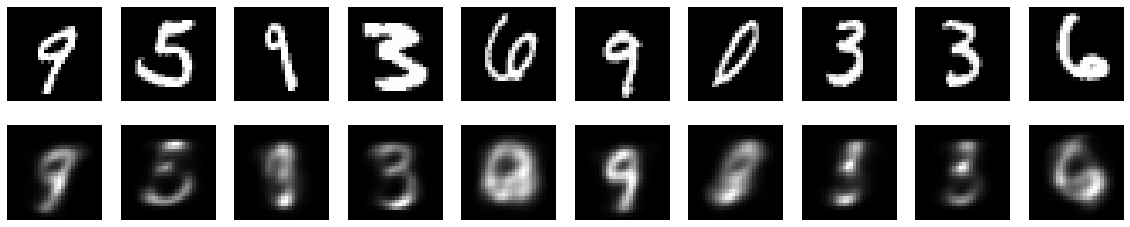

In [23]:
# number of images to plot
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    index = random.randint(0,len(x_test))
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Denoising AutoEncoder

In [25]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

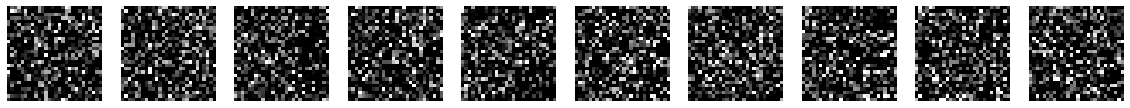

In [26]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [32]:
def AutoEncoder(input_shape=(28,28,1)):
    
    # Input Image
    X_input = Input(shape=input_shape,name = "input")
    
    X = Conv2D(32, (3,3), activation='relu', padding='same', name="conv0")(X_input)
    X = MaxPooling2D((2,2), padding='same', name = 'max0')(X)
    X = Conv2D(32, (3,3), activation='relu', padding='same', name="conv1")(X)
    encoded = MaxPooling2D((2,2), padding='same', name = 'encoded')(X)
    
    X = Conv2D(32, (3,3), activation='relu', padding='same', name="conv2")(encoded)
    X = UpSampling2D((2,2), name = 'upsample0')(X)
    X = Conv2D(32, (3,3), activation='relu', padding='same', name="conv3")(X)
    X = UpSampling2D((2,2), name = 'upsample1')(X)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(X)
    
    # Model that maps input to its reconstruction
    model = Model(inputs = X_input, outputs = decoded, name='AutoEncoder')

    return model

In [35]:
autoencoder = AutoEncoder()

In [36]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
max0 (MaxPooling2D)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 32)        9248      
_________________________________________________________________
encoded (MaxPooling2D)       (None, 7, 7, 32)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 32)          9248      
_________________________________________________________________
upsample0 (UpSampling2D)     (None, 14, 14, 32)        0         
__________

In [37]:
autoencoder.compile(optimizer = 'adam' , loss = 'binary_crossentropy')

In [ ]:
from tensorflow.python.keras.callbacks import TensorBoard

history = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 108s 2ms/step - loss: 2.3840e-04 - val_loss: 1.6345e-04
Epoch 2/100
50000/50000 [==============================] - 104s 2ms/step - loss: 1.2468e-04 - val_loss: 9.4975e-05
Epoch 3/100
50000/50000 [==============================] - 100s 2ms/step - loss: 7.8641e-05 - val_loss: 6.5582e-05
Epoch 4/100
50000/50000 [==============================] - 102s 2ms/step - loss: 5.7653e-05 - val_loss: 5.1147e-05
Epoch 5/100
50000/50000 [==============================] - 114s 2ms/step - loss: 4.6810e-05 - val_loss: 4.3261e-05
Epoch 6/100
50000/50000 [==============================] - 105s 2ms/step - loss: 4.0657e-05 - val_loss: 3.8600e-05
Epoch 7/100
50000/50000 [==============================] - 93s 2ms/step - loss: 3.6919e-05 - val_loss: 3.5684e-05
Epoch 8/100
50000/50000 [==============================] - 92s 2ms/step - loss: 3.4528e-05 - val_loss: 3.3782e-05
Epoch 9/100
50000/50000 [=======

In [ ]:
layer_name = 'decoded'
decoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)
decoded_imgs = decoder.predict(x_test_noisy)

In [ ]:
# number of images to plot
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    index = random.randint(0,len(x_test))
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()